In [1]:
%cd "/home/plent/Documenten/Gitlab/Coumaric_Acid_V2"
from itertools import combinations,product
import numpy as np
from scipy.special import softmax
import matplotlib.pyplot as plt
import xgboost as xgb
import pandas as pd
from scipy.stats import entropy


/home/plent/Documenten/Gitlab/Coumaric_Acid_V2


In [2]:

# ['Sc_PFY1.pro-Sc_RKI1.orf']

### This notebook generates the designs for the DoE round
New is;
1. A retrained model with a better preprocessing step
2. Multiple promoter values per gene

In [3]:
bst = xgb.Booster({'nthread': 4}) 
bst.load_model('results/ML_Models/140624_XGBoost_retrained.model')

#find the dimensionalities from the training data
data=pd.read_csv('data/processed/IntegratedData_WURTUD/strain_numeric_matrix.csv',index_col=0)



gene_names=list(data.columns)

promoter_strengths=pd.read_csv("data/processed/GFP_PromoterStrengths/quantified_promoter_strength_rewritten.csv",index_col=0)
promoter_strengths=promoter_strengths.sort_values(by="FI")
promoter_strengths=promoter_strengths.to_dict()['FI']




In [4]:



# N choose k, where N is the number of possible promoters (4) times the gene names (19).
K=4
promoter_strengths_s=["Sc_VMA6","Sc_RPL28","Sc_RPL8A","Sc_ENO2"] #choose promoters such that there is atleast unique and weaker one for filling of the designs later

def get_possible_actions(promoter_strengths_s,gene_names,K):
    """N choose K actions with only unique genes"""
    combinations_list=product(promoter_strengths_s,gene_names)


    NchooseK_designs=list(combinations(combinations_list,K))
    NchooseK_designs = [np.array(i) for i in NchooseK_designs]

    NchooseK_designs_unique_orfs=[]
    for design in NchooseK_designs:
        #check whether each design has an unique orf (no gene homologies within one strain)
        if len(np.unique(design[:,1]))==K: 
            NchooseK_designs_unique_orfs.append(design)

    return NchooseK_designs_unique_orfs


NchooseK_designs_unique_orfs=get_possible_actions(promoter_strengths_s,gene_names,K)


In [5]:
len(NchooseK_designs_unique_orfs)

992256

### Here, we define the parent strain used in the DoE.

In [6]:
# this part, we change the parent strain based on an already succeeded strain
parent_strain=data.loc['SHK0066'] #shk0066
parent_strain2=parent_strain.copy()


top4_strain=parent_strain.copy()
top4_strain['Sc_PHA2.orf']=np.log10(10**top4_strain['Sc_PHA2.orf']+10**promoter_strengths['Sc_RPL8A'])
top4_strain['Sc_ARO4_OFP.orf_0001']=np.log10(10**top4_strain['Sc_PHA2.orf']+10**promoter_strengths['Sc_TDH3'])
top4_strain['Sc_ARO2.orf']=np.log10(10**top4_strain['Sc_ARO2.orf']+10**promoter_strengths['Sc_RPS9A'])
top4_strain['Sc_RKI1.orf_0002']=np.log10(10**top4_strain['Sc_RKI1.orf_0002']+10**promoter_strengths['Sc_PRE3'])

# promoter_strengths['Sc_CHO1'] #PAL1
# promoter_strengths['Sc_PRE3'] #TKL1
# promoter_strengths['Sc_ENO2'] #ARO4
# promoter_strengths['Sc_PGK1'] #ENO2
# promoter_strengths['Sc_RPS3'] #ARO8
#
parent_strain2['Atha_PAL1.orf']=np.log10(10**parent_strain2['Atha_PAL1.orf']+10**promoter_strengths['Sc_CHO1'])
parent_strain2['Sc_TKL1.orf_0001']=np.log10(10**parent_strain2['Sc_TKL1.orf_0001']+10**promoter_strengths['Sc_PRE3'])
parent_strain2['Sc_ARO4_OFP.orf_0001']=np.log10(10**parent_strain2['Sc_ARO4_OFP.orf_0001']+10**promoter_strengths['Sc_ENO2'])
parent_strain2['Sc_ENO2.orf']=np.log10(10**parent_strain2['Sc_ENO2.orf']+10**promoter_strengths['Sc_PGK1'])
parent_strain2['Sc_ARO8.orf_0001']=np.log10(10**parent_strain2['Sc_ARO8.orf_0001']+10**promoter_strengths['Sc_RPS3'])
#
parent_strain3=parent_strain.copy()
parent_strain3['Sc_PHA2.orf']=np.log10(10**parent_strain['Sc_PHA2.orf']+10**promoter_strengths['Sc_PFY1'])
parent_strain3['Atha_PAL1.orf']=np.log10(10**parent_strain['Atha_PAL1.orf']+10**promoter_strengths['Sc_ENO2'])
parent_strain3['Atha_C4H.orf']=np.log10(10**parent_strain['Atha_C4H.orf']+10**promoter_strengths['Sc_TDH3'])

parent_strain3-parent_strain

Atha_C4H.orf            0.246065
Atha_CPR1.orf           0.000000
Atha_PAL1.orf           0.204143
Ec_AROL.orf             0.000000
Sc_ARO1.orf             0.000000
Sc_ARO2.orf             0.000000
Sc_ARO4_OFP.orf_0001    0.000000
Sc_ARO8.orf_0001        0.000000
Sc_ENO2.orf             0.000000
Sc_FBA1.orf             0.000000
Sc_GND1.orf             0.000000
Sc_GND2.orf             0.000000
Sc_PHA2.orf             3.981765
Sc_RKI1.orf_0002        0.000000
Sc_SOL3.orf_0001        0.000000
Sc_SOL4.orf             0.000000
Sc_TKL1.orf_0001        0.000000
Sc_YHM2.orf             0.000000
Sc_ZWF1.orf             0.000000
Name: SHK0066, dtype: float64

In [7]:



def generate_strain_design(design,ref_strain, promoter_strengths):
    """Generates a design given a reference strain. Named promoters are replaced by numbers from GFP screening and are added on the logscale"""
    genes=design[:,1]

    new_strain=ref_strain.copy()
    for i in range(len(genes)):
        new_strain.loc[genes[i]]=np.log10(10**new_strain.loc[genes[i]]+10**promoter_strengths[design[i,0]])
    return new_strain.to_dict()

formatted_designs=[]
for design in NchooseK_designs_unique_orfs:
    design=generate_strain_design(design,ref_strain=parent_strain,promoter_strengths=promoter_strengths)
    formatted_designs.append(design)
        # promoter_strengths

In [8]:
formatted_designs=pd.DataFrame(formatted_designs)
formatted_designs=xgb.DMatrix(formatted_designs)
pred_strains=bst.predict(formatted_designs)


In [9]:
bst.predict(xgb.DMatrix(top4_strain.values.reshape(1,len(top4_strain))))

array([2.174261], dtype=float32)

In [30]:

def get_design_stats(selected_combinations):
    """Outputs some stats about that is generated through the softmax approach"""
    genes_all=[]
    for i in range(len(selected_combinations)):
        genes=selected_combinations[i][:,1]
        genes_all.append(genes)
    genes_all=np.array(genes_all).flatten()
    unique_genes,counts=np.unique(genes_all,return_counts=True )

    return len(unique_genes),unique_genes,counts


# alpha=25
softmax_distribution=softmax(pred_strains*1000)
selected_indices=np.random.choice(np.arange(0,len(softmax_distribution)),size=20,replace=False,p=softmax_distribution)
selected_combinations=[NchooseK_designs_unique_orfs[i] for i in selected_indices]
# get_design_stats()

# # selected_combinations
ngenes,unique_genes,counts=get_design_stats(selected_combinations)

ngenes


ngenes

7

### When alpha increases, diversity of the DoE declines (because important genes are chosen more often), but average p-ca production goes up. It is therefore an exploration/exploitation parameter, but not on the 0-1 interval.

In [52]:
t=128
step=2
temperatures1=np.arange(1,t,step)
temperatures2=1/np.arange(1,t,step)[::-1]
temperatures=np.concatenate((temperatures2,temperatures1))

ngenes_per_alpha=[]
ngenes_per_alpha_std=[]
average_production_per_alpha=[]
average_production_per_alpha_std=[]

max_production_per_alpha=[]
max_production_per_alpha_std=[]

median_production_per_alpha=[]
median_production_per_alpha_std=[]

var_production_per_alpha=[]
var_production_per_alpha_std=[]

entropy_per_alpha=[]
entropy_per_alpha_std=[]

for temp in temperatures:
    print(temp)
    # print(alpha)
    m_genes=[]
    m_pred=[]
    max_pred=[]
    variance_pred=[]
    softmax_distribution=softmax(pred_strains*temp)
    for k in range(200):
        
        selected_indices=np.random.choice(np.arange(0,len(softmax_distribution)),size=30,replace=False,p=softmax_distribution)
        selected_combinations=[NchooseK_designs_unique_orfs[i] for i in selected_indices]
        # get_design_stats()

        # selected_combinations
        ngenes,unique_genes,counts=get_design_stats(selected_combinations)
        strain_pred=pred_strains[selected_indices]
        
        #get the mean, maximum and number of genes
        m_pred.append(np.mean(strain_pred))
        variance_pred=np.var(strain_pred)
        max_pred.append(np.max(strain_pred))
        the_entropy=entropy(counts)

        m_genes.append(ngenes)

    entropy_per_alpha.append(np.mean(the_entropy))
    entropy_per_alpha_std.append(np.std(the_entropy))

    ngenes_per_alpha.append(np.mean(m_genes))
    ngenes_per_alpha_std.append(np.std(m_genes))

    average_production_per_alpha.append(np.mean(m_pred))
    average_production_per_alpha_std.append(np.std(m_pred))

    max_production_per_alpha.append(np.mean(max_pred))
    max_production_per_alpha_std.append(np.std(max_pred))

    var_production_per_alpha.append(np.mean(variance_pred))
    var_production_per_alpha_std.append(np.std(variance_pred))
    # median_production_per_alpha.append(np.median(m_pred))




0.007874015748031496
0.008
0.008130081300813009
0.008264462809917356
0.008403361344537815
0.008547008547008548
0.008695652173913044
0.008849557522123894
0.009009009009009009
0.009174311926605505
0.009345794392523364
0.009523809523809525
0.009708737864077669
0.009900990099009901
0.010101010101010102
0.010309278350515464
0.010526315789473684
0.010752688172043012
0.01098901098901099
0.011235955056179775
0.011494252873563218
0.011764705882352941
0.012048192771084338
0.012345679012345678
0.012658227848101266
0.012987012987012988
0.013333333333333334
0.0136986301369863
0.014084507042253521
0.014492753623188406
0.014925373134328358
0.015384615384615385
0.015873015873015872
0.01639344262295082
0.01694915254237288
0.017543859649122806
0.01818181818181818
0.018867924528301886
0.0196078431372549
0.02040816326530612
0.02127659574468085
0.022222222222222223
0.023255813953488372
0.024390243902439025
0.02564102564102564
0.02702702702702703
0.02857142857142857
0.030303030303030304
0.03225806451612903


In [53]:
for_saving={"temperatures":temperatures,"max_production_per_alpha":max_production_per_alpha,"max_production_per_alpha_std":max_production_per_alpha_std,"average_production_per_alpha":average_production_per_alpha,
            "average_production_per_alpha_std":average_production_per_alpha_std,
            "ngenes_per_alpha":ngenes_per_alpha,"ngenes_per_alpha_std":ngenes_per_alpha_std,"var_per_alpha":var_production_per_alpha,"var_per_alpha_std":var_production_per_alpha_std,
            "entropy_per_alpha": entropy_per_alpha,"entropy_per_alpha_std":entropy_per_alpha_std,'entropy_per_alpha':entropy_per_alpha}

for_saving=pd.DataFrame(for_saving)
for_saving.to_csv("results/FollowUpRound/010724_temperature_parameter_values_parent_strain.csv")
# 
for_saving=pd.read_csv("results/FollowUpRound/010724_temperature_parameter_values_parent_strain.csv",index_col=0)

In [54]:
temperatures=for_saving['temperatures']
ngenes_per_alpha=for_saving['ngenes_per_alpha']
ngenes_per_alpha_std=for_saving['ngenes_per_alpha_std']
entropy_per_alpha=for_saving['entropy_per_alpha']
entropy_per_alpha_std=for_saving['entropy_per_alpha_std']

average_production_per_alpha=for_saving['average_production_per_alpha']
average_production_per_alpha_std=for_saving['average_production_per_alpha_std']
max_production_per_alpha=for_saving['max_production_per_alpha']
max_production_per_alpha_std=for_saving['max_production_per_alpha_std']
var_production_per_alpha=for_saving['var_per_alpha']
var_production_per_alpha_std=for_saving['var_per_alpha_std']





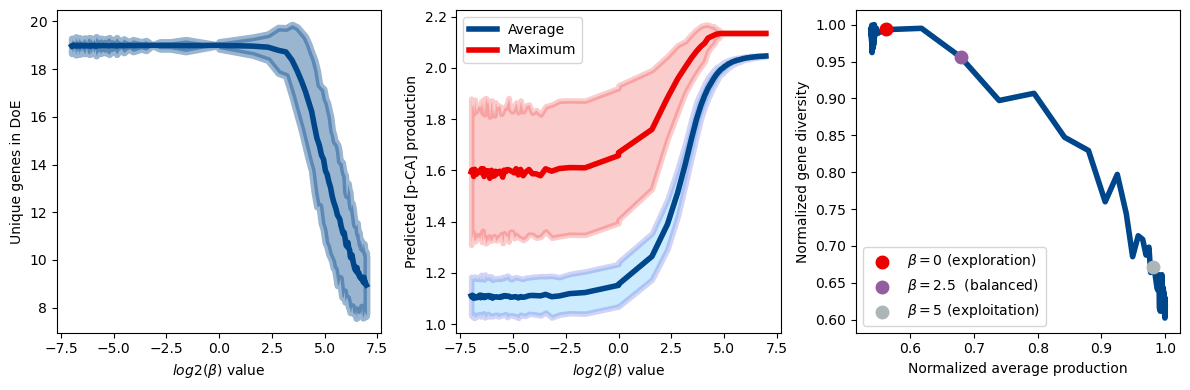

In [66]:
%matplotlib inline

fig,axes=plt.subplots(1,3, figsize=(12,4))
axes[0].plot(np.log2(temperatures),ngenes_per_alpha,color="#00468BFF",linewidth=4)

axes[0].fill_between(np.log2(temperatures), np.array(ngenes_per_alpha)-2*np.array(ngenes_per_alpha_std), np.array(ngenes_per_alpha)+2*np.array(ngenes_per_alpha_std),
     alpha=0.4,edgecolor='#00468BFF', facecolor='#00468BFF',
    linewidth=5, antialiased=True, rasterized=False)

axes[0].set_xlabel("$log2( \\beta ) $ value")
axes[0].set_ylabel("Unique genes in DoE")
axes[0].grid(False)




axes[1].plot(np.log2(temperatures),average_production_per_alpha,color="#00468BFF", label="Average",linewidth=4)
axes[1].fill_between(np.log2(temperatures), np.array(average_production_per_alpha)-2*np.array(average_production_per_alpha_std), np.array(average_production_per_alpha)+2*np.array(average_production_per_alpha_std),
    alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
    linewidth=4, antialiased=True)
axes[1].set_xlabel("$log2( \\beta) $ value")
axes[1].set_ylabel("Predicted [p-CA] production")

axes[1].grid(False)
axes[1].plot(np.log2(temperatures),max_production_per_alpha, color="#ED0000FF", label="Maximum",linewidth=4)
axes[1].fill_between(np.log2(temperatures), np.array(max_production_per_alpha)-2*np.array(max_production_per_alpha_std), np.array(max_production_per_alpha)+2*np.array(max_production_per_alpha_std),
    alpha=0.2, edgecolor='#ED0000FF', facecolor='#ED0000FF',
    linewidth=4, antialiased=True)

axes[1].legend(loc="upper left")

normalized_gene_diversity = np.array(ngenes_per_alpha)/np.max(ngenes_per_alpha)
normalized_gene_diversity = np.array(entropy_per_alpha)/np.max(entropy_per_alpha)

normalized_average_production=np.array(average_production_per_alpha)/np.max(average_production_per_alpha)
normalized_max_production=np.array(max_production_per_alpha)/np.max(max_production_per_alpha)


axes[2].grid(False)
axes[2].plot(normalized_average_production,normalized_gene_diversity, color="#00468BFF",linewidth=4)

axes[2].scatter(normalized_average_production[63],normalized_gene_diversity[63],
                label="$\\beta=0$ (exploration)",color="#ED0000FF",linewidth=4, zorder=5)
axes[2].scatter(normalized_average_production[66],normalized_gene_diversity[66],
                label="$\\beta=2.5$  (balanced)",color="#925E9FFF",linewidth=4, zorder=5)
axes[2].scatter(normalized_average_production[80],normalized_gene_diversity[80],
                label="$\\beta=5$ (exploitation)" ,color="#ADB6B6FF",linewidth=4, zorder=5)
axes[2].set_xlabel("Normalized average production")
axes[2].set_ylabel("Normalized gene diversity")
axes[2].legend(loc="lower left")
fig.tight_layout()
fig.savefig("figures/ExploreExploit/parent_strain_explore_exploit.png")
fig.savefig("figures/ExploreExploit/parent_strain_explore_exploit.svg")

In [60]:
def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return idx

find_nearest(np.log2(temperatures),5)

# 0 31
# 2.5 33
# 5 40

80

average performance of set 2.3343704
unique genes in set 18


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
 [Text(0, 0, 'Atha_C4H.orf'),
  Text(1, 0, 'Atha_CPR1.orf'),
  Text(2, 0, 'Atha_PAL1.orf'),
  Text(3, 0, 'Ec_AROL.orf'),
  Text(4, 0, 'Sc_ARO1.orf'),
  Text(5, 0, 'Sc_ARO2.orf'),
  Text(6, 0, 'Sc_ARO4_OFP.orf_0001'),
  Text(7, 0, 'Sc_ARO8.orf_0001'),
  Text(8, 0, 'Sc_ENO2.orf'),
  Text(9, 0, 'Sc_GND1.orf'),
  Text(10, 0, 'Sc_GND2.orf'),
  Text(11, 0, 'Sc_PHA2.orf'),
  Text(12, 0, 'Sc_RKI1.orf_0002'),
  Text(13, 0, 'Sc_SOL3.orf_0001'),
  Text(14, 0, 'Sc_SOL4.orf'),
  Text(15, 0, 'Sc_TKL1.orf_0001'),
  Text(16, 0, 'Sc_YHM2.orf'),
  Text(17, 0, 'Sc_ZWF1.orf')])

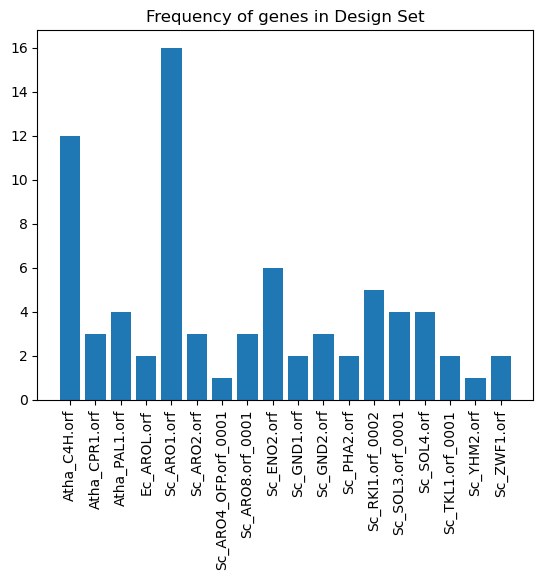

In [35]:
import random
np.random.seed(1) #Code B

alpha=2**5 #this is the parameter you can change based on the curves above
softmax_distribution=softmax(pred_strains*alpha)
selected_indices=np.random.choice(np.arange(0,len(softmax_distribution)),size=25,replace=False,p=softmax_distribution)

selected_combinations=[NchooseK_designs_unique_orfs[i] for i in selected_indices]
# get_design_stats()

# selected_combinations
ngenes,unique_genes,counts=get_design_stats(selected_combinations)
strain_pred=pred_strains[selected_indices]




## design matrix
matrix=np.zeros((20,8),dtype="str")

my_dict={}
for i in range(len(selected_combinations)):
    line=np.array(selected_combinations[i].flatten())
    my_dict["strain"+str(i)]=line
design_df=pd.DataFrame(my_dict).T

design_df.columns=["Pro1","Orf1","Pro2","Orf2","Pro3","Orf3","Pro4","Orf4"]

print("average performance of set",np.mean(strain_pred))
unique_genes=design_df.filter(items=["Orf1","Orf2","Orf3"])

print("unique genes in set",len(np.unique(unique_genes)))
design_df['Predicted_Production']=strain_pred

plt.title("Frequency of genes in Design Set")
plt.bar(np.unique(unique_genes,return_counts=True)[0],np.unique(unique_genes,return_counts=True)[1])
plt.xticks(rotation=90)

In [36]:

design_df.to_csv("results/TUD_Round/DoE_round2/010725_top4_logbeta=5_designs.csv")